In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
import calendar
import seaborn as sn
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

In [3]:
train = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
train.shape

(10886, 12)

In [7]:
test.shape

(6493, 9)

In [8]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

We would have to convert datetime into int format


In [9]:
year = []
month = []
day = []
time = []
for i in range(len(train)):
    year.append(int(train["datetime"].values[i].split()[0].split("-")[0]))
    month.append(int(train["datetime"].values[i].split()[0].split("-")[1]))
    day.append(int(train["datetime"].values[i].split()[0].split("-")[2]))
    time.append(int(train["datetime"].values[i].split()[1].split(":")[0]))
train["year"] = year
train["month"] = month
train["day"] = day
train["time"] = time

In [10]:
year = []
month = []
day = []
time = []
for i in range(len(test)):
    year.append(int(test["datetime"].values[i].split()[0].split("-")[0]))
    month.append(int(test["datetime"].values[i].split()[0].split("-")[1]))
    day.append(int(test["datetime"].values[i].split()[0].split("-")[2]))
    time.append(int(test["datetime"].values[i].split()[1].split(":")[0]))
test["year"] = year
test["month"] = month
test["day"] = day
test["time"] = time

In [11]:
train.drop(['datetime'],inplace=True,axis=1)
test.drop(['datetime'],inplace=True,axis=1)

In [12]:
train.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
time          0
dtype: int64

Exploring Features


In [13]:
train.season.value_counts()

season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

In [14]:
train.holiday.value_counts()

holiday
0    10575
1      311
Name: count, dtype: int64

In [15]:
train.workingday.value_counts()

workingday
1    7412
0    3474
Name: count, dtype: int64

In [16]:
train.weather.value_counts()

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

In [17]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,time
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000


# Finding Outliers via BoxPlot

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

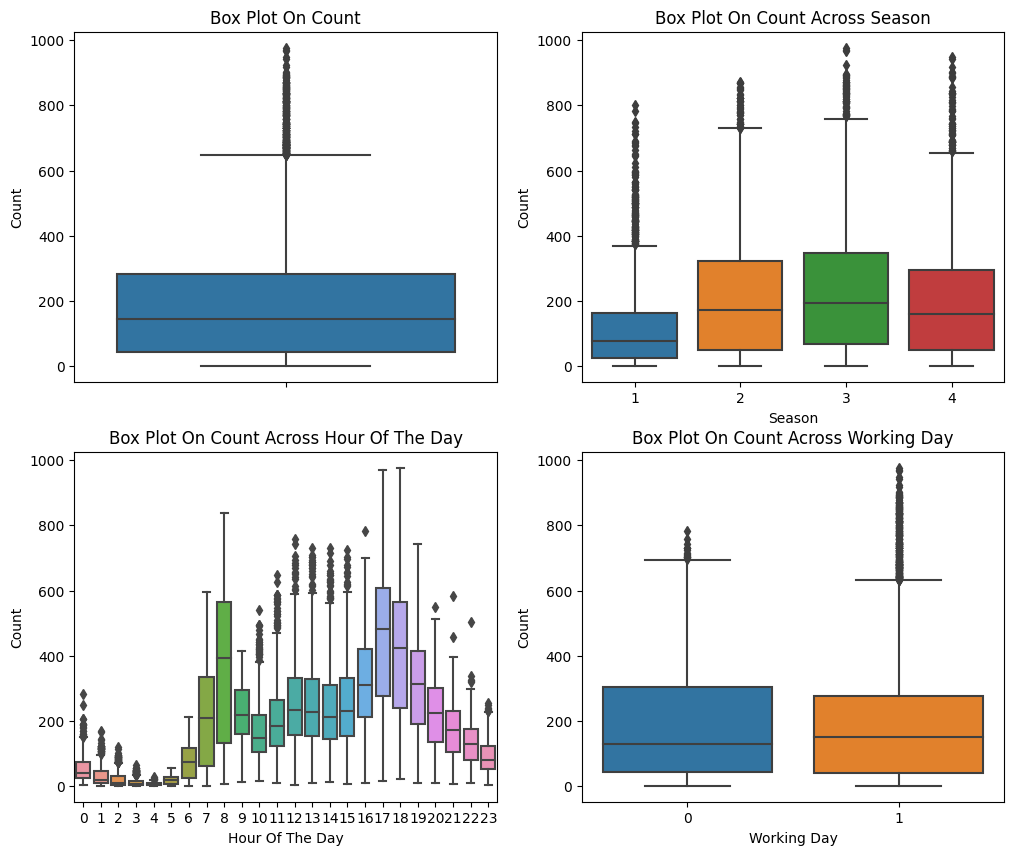

In [18]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sn.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sn.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sn.boxplot(data=train,y="count",x="time",orient="v",ax=axes[1][0])
sn.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

In [19]:
train_Without_Outliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())] 

In [20]:
print ("Shape Of The Before Ouliers: ",train.shape)
print ("Shape Of The After Ouliers: ",train_Without_Outliers.shape)

Shape Of The Before Ouliers:  (10886, 15)
Shape Of The After Ouliers:  (10739, 15)


In [21]:
train=train_Without_Outliers

# Plotting Month wise Demand 

<BarContainer object of 12 artists>

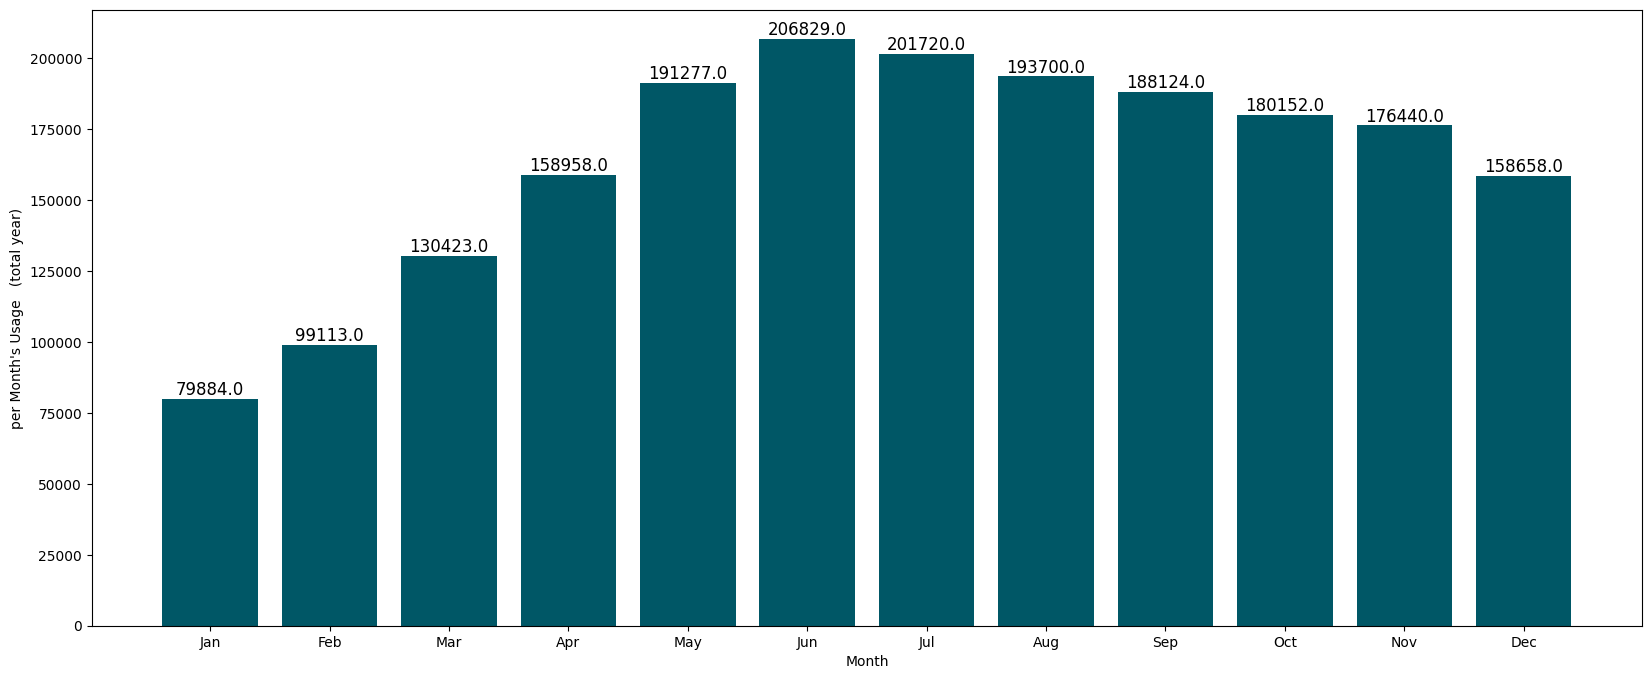

In [22]:
x = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
y = []
for i in range(1,13):
    y.append(train[train["month"]==i]["count"].sum())
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.title("")
plt.xlabel("Month")
plt.ylabel("per Month's Usage   (total year)")
plt.bar(x,y,color = '#005766')

Maximum usage is in June to Oct which can be though as a period between summer and autumn 

# Plotting hour wise data 

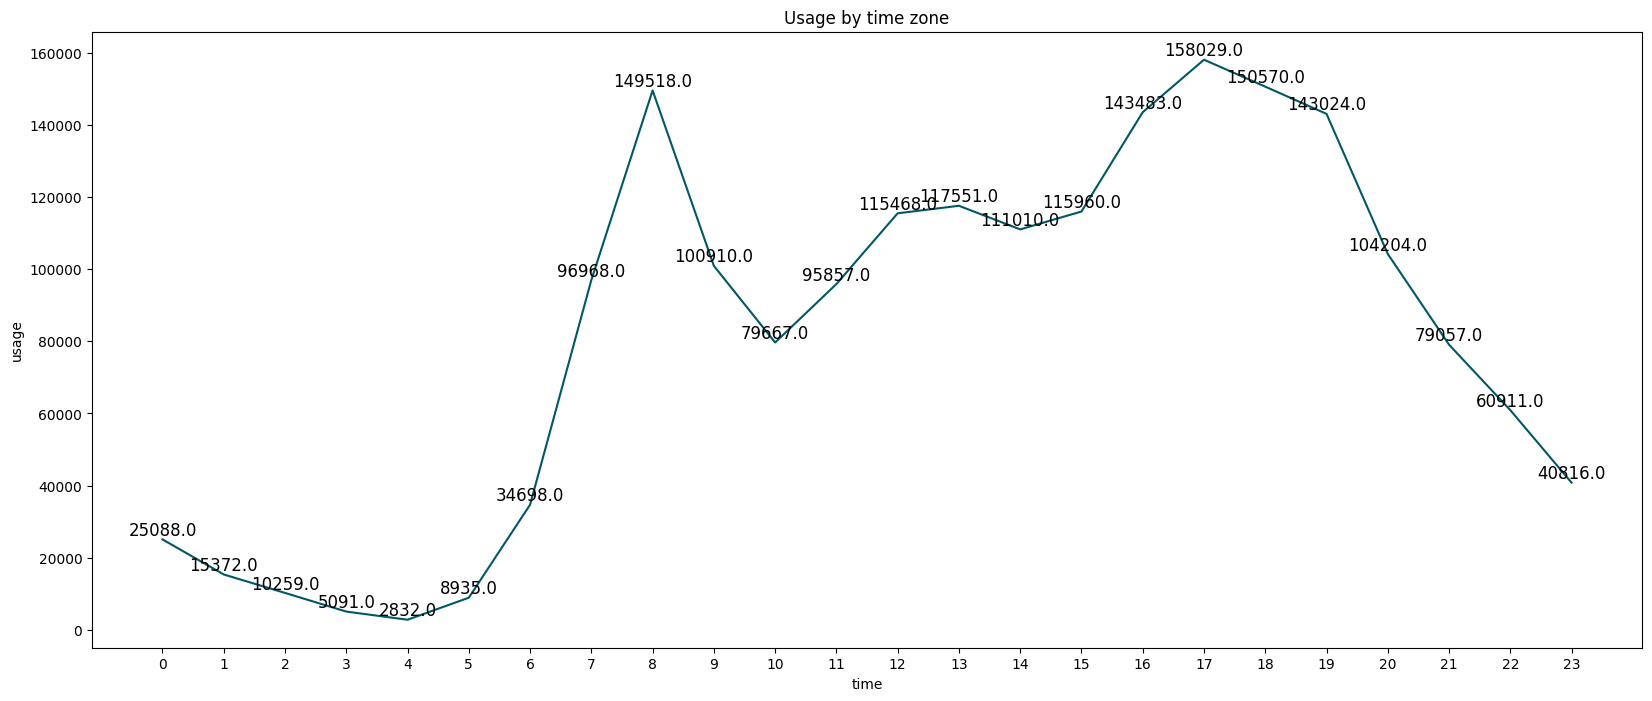

In [23]:
x = []
for i in range(24):
    x.append(str(i))
y = []
for i in range(24):
    y.append(train[train["time"]==i]["count"].sum())
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)
plt.title("Usage by time zone")
plt.xlabel("time")
plt.ylabel("usage")
plt.plot(x,y,color = '#005766')

The usage is high from 7 a.m -9 a.m. and 4 p.m -7 p.m. 
And moderate in between 10 a.m - 3 p.m. 

The reason could be due to office hours. So to check for the same we have to look for holidays and weekdays.

# Plotting Workingday, Holiday - by time

In [24]:
#As we have WorkingDay and Holiday so we can make a function and call for both of them individually.
def time_feature_rel(b,a):
    y = []
    for i in range(24):
        y.append(train[(train["time"]==i) & (train[b]==a)]["count"].sum())
    x = []
    for i in range(24):
        x.append(str(i))
    plt.figure(figsize=(20,8))
    for i in range(len(x)):
        height = y[i]
        plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)
    plt.title(b +"-" +str(a))
    plt.xlabel("time")
    plt.ylabel("usage")
    plt.plot(x,y)

In [25]:
working_day_1=print(train['workingday'].value_counts()[1])
working_day_0=print(train['workingday'].value_counts()[0])

7268
3471


In [26]:
holiday_1=print(train['holiday'].value_counts()[1])
holdiday_0=print(train['holiday'].value_counts()[0])

311
10428


# Working_Day

Let's club Holiday=0 and Workingday=1

None
None


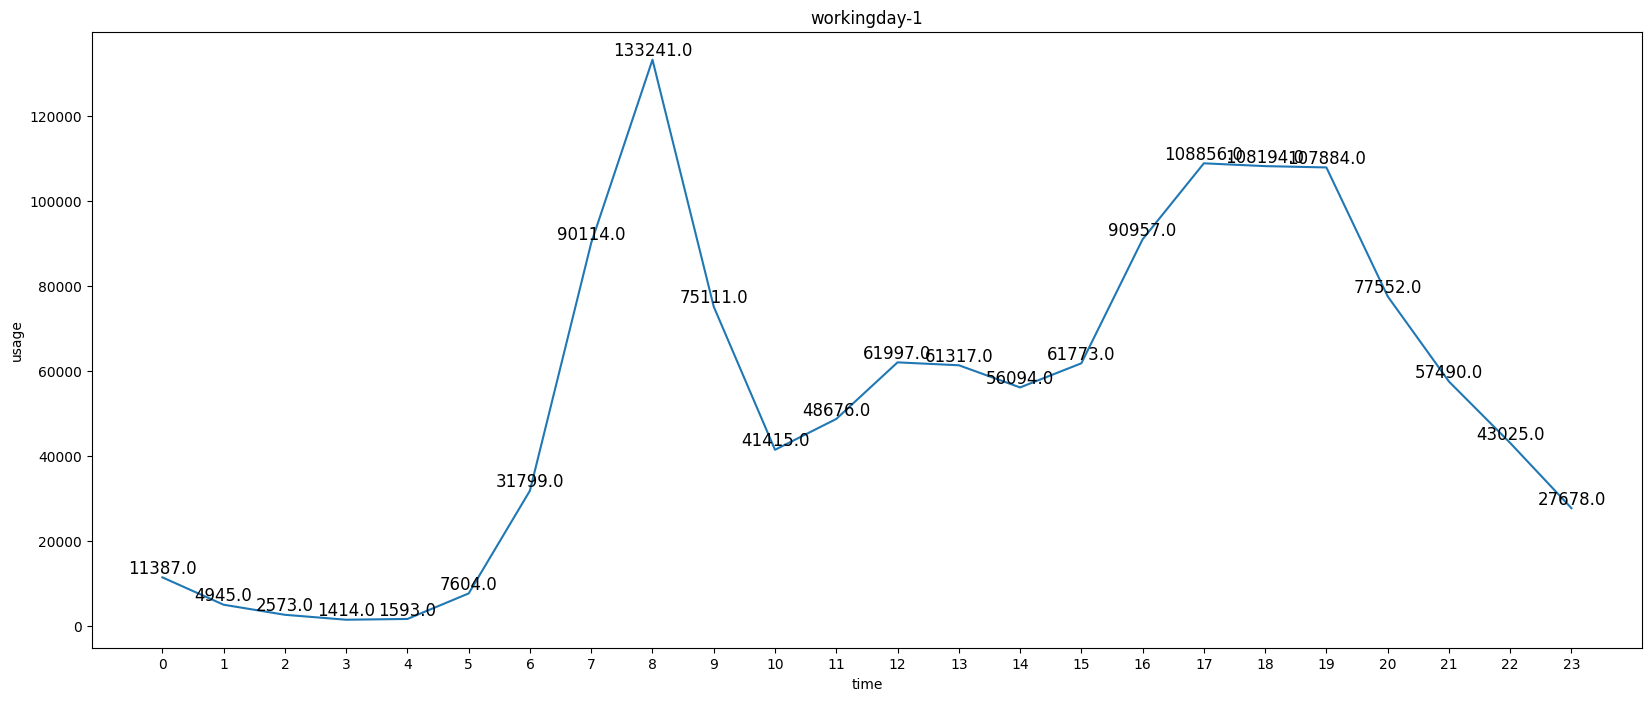

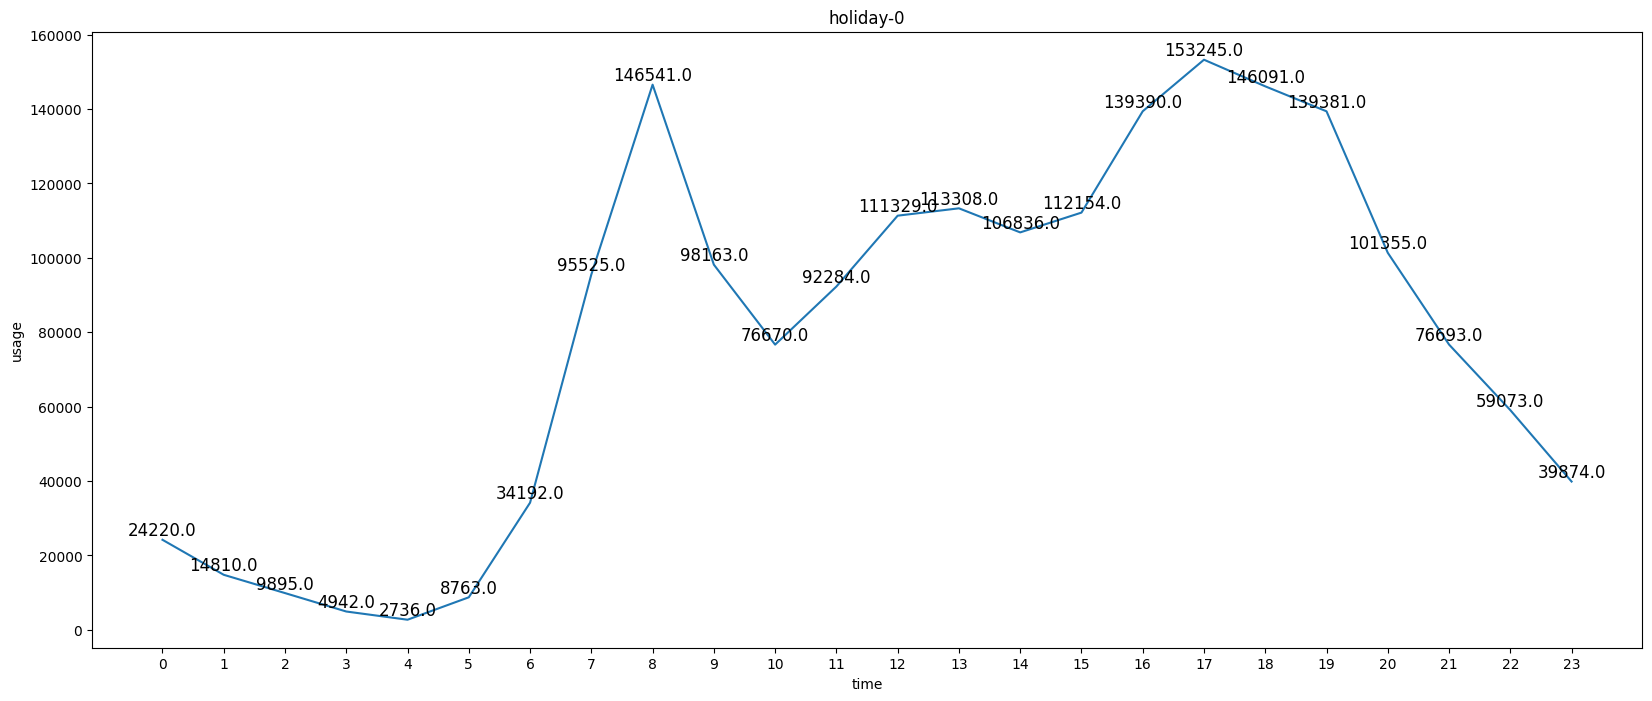

In [27]:
print(time_feature_rel("workingday",1))
print(time_feature_rel("holiday",0))

# Holiday

Let's club Holiday=1 and Workingday=0

None
None


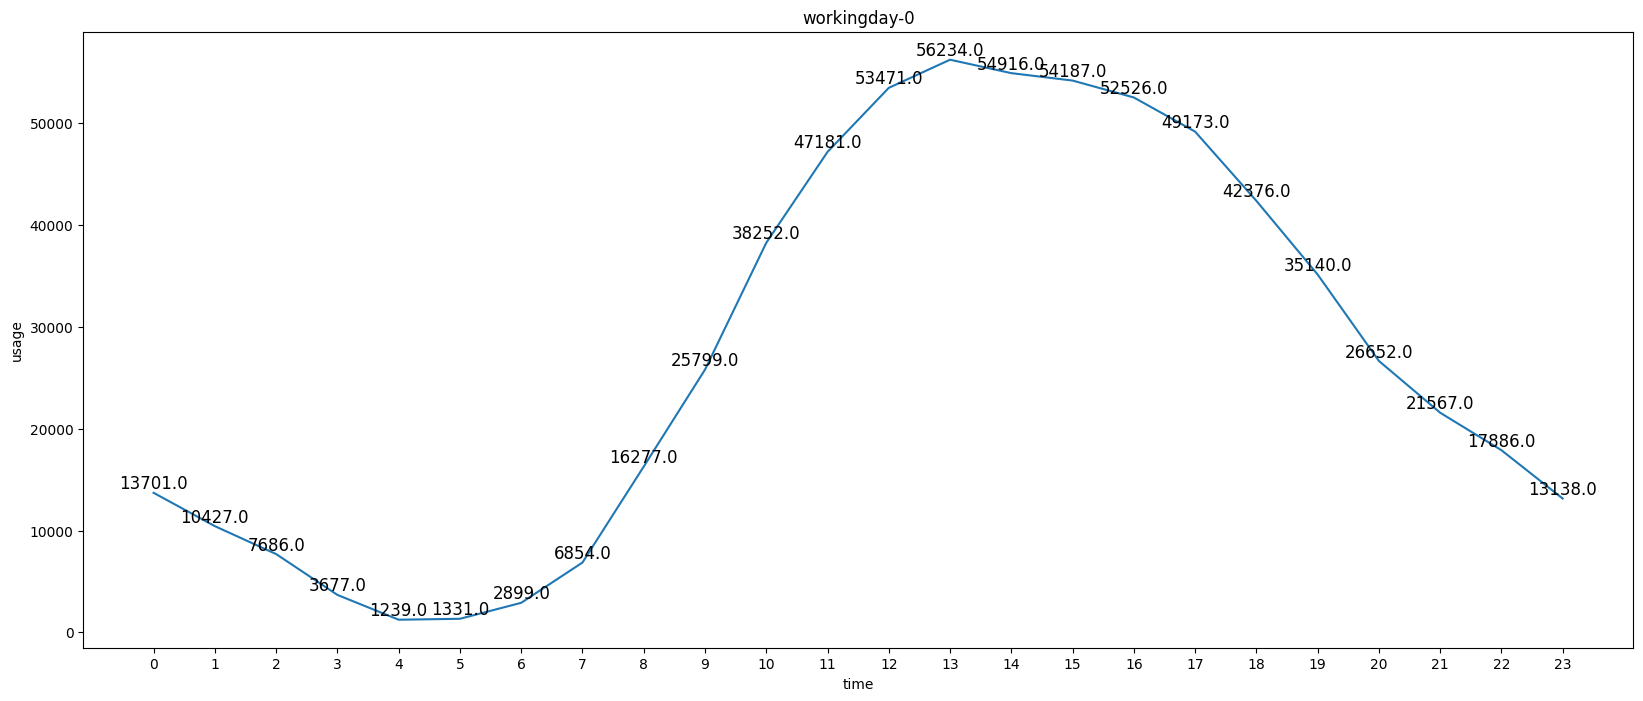

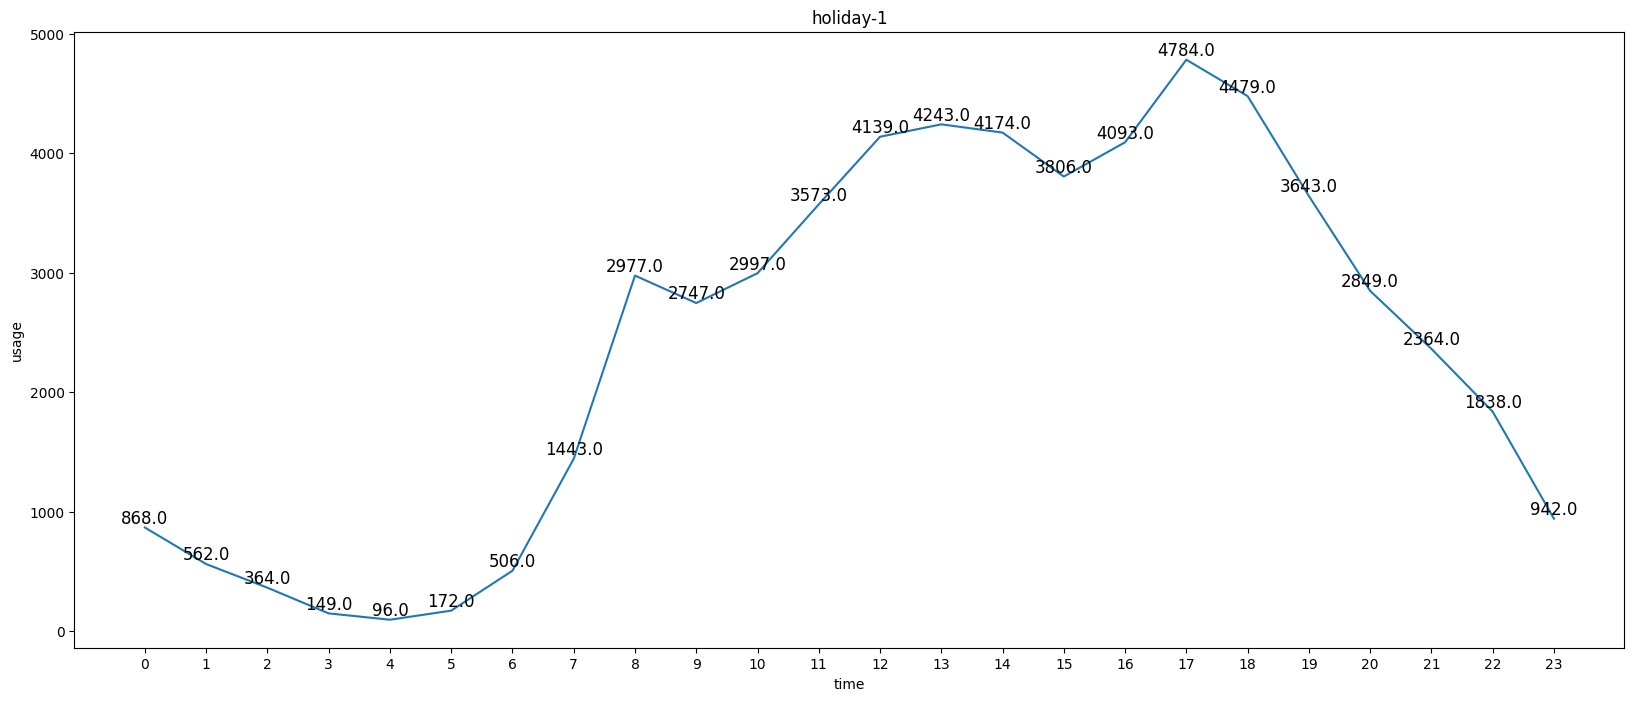

In [28]:
print(time_feature_rel("workingday",0))
print(time_feature_rel("holiday",1))

The amount of bicycle loans increased sharply during rush hour on working days, but on the contrary, on holidays, it recorded a high amount of bicycle loans at 1 p.m.

# Humidity

In [29]:
train["humidity"].value_counts().sort_index()

humidity
0       22
8        1
10       1
12       1
13       1
      ... 
93     205
94     324
96       1
97       1
100    148
Name: count, Length: 89, dtype: int64

<Axes: xlabel='count', ylabel='Density'>

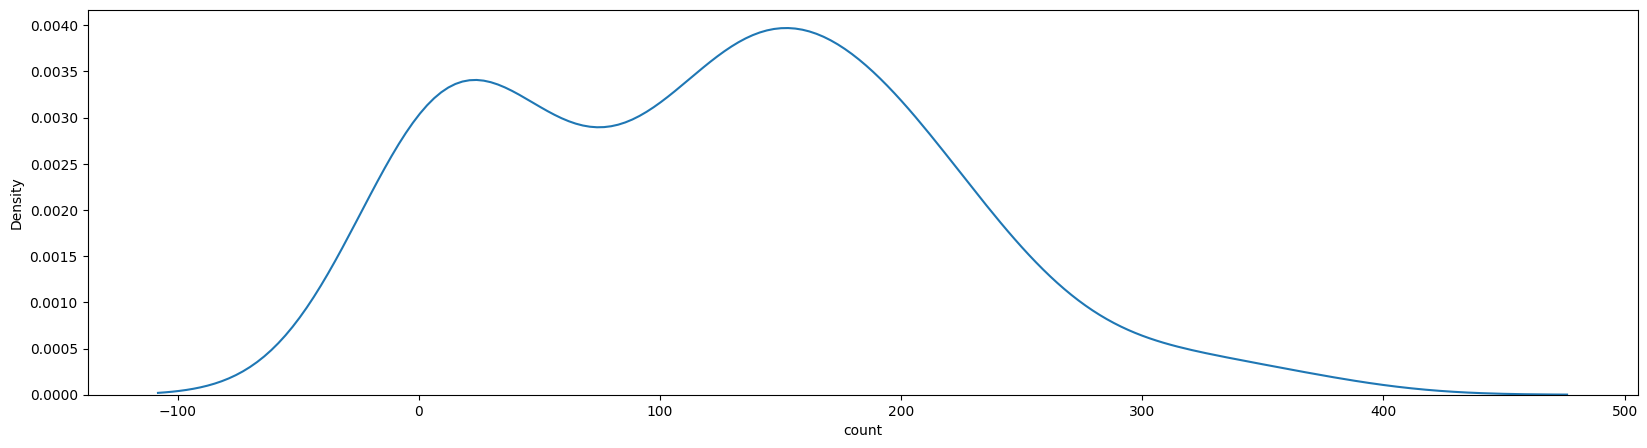

In [30]:
plt.figure(figsize=(20,5))
sn.kdeplot(train["humidity"].value_counts().sort_index())

As no proper visualization or summary can be obtained from watching this graph we have to do proper mapping.

Since it is a data format of various and irregular patterns, it is necessary to add efficiency to visualization and machine learning analysis through mapping.

As data is divided between 1 and 100 we can distribute the data in intervals of 10.

# Humidity change on Train Set

In [31]:
mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []
mapping60_70 = []
mapping70_80 = []
mapping80_90 = []
mapping90_100 = []
for i in range(len(train["humidity"].value_counts())):
    dd = []
    if 1 <= train["humidity"].value_counts().sort_index().index[i] < 10:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping1_10.append(train["humidity"].value_counts().sort_index().index[i])
    elif 10<= train["humidity"].value_counts().sort_index().index[i] < 20:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping10_20.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 20<= train["humidity"].value_counts().sort_index().index[i] < 30:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping20_30.append(train["humidity"].value_counts().sort_index().index[i])
    elif 30<= train["humidity"].value_counts().sort_index().index[i] < 40:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping30_40.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 40<= train["humidity"].value_counts().sort_index().index[i] < 50:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping40_50.append(train["humidity"].value_counts().sort_index().index[i])
    elif 50<= train["humidity"].value_counts().sort_index().index[i] < 60:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping50_60.append(train["humidity"].value_counts().sort_index().index[i])    
    elif 60<= train["humidity"].value_counts().sort_index().index[i] < 70:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping60_70.append(train["humidity"].value_counts().sort_index().index[i])
    elif 70<= train["humidity"].value_counts().sort_index().index[i] < 80:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping70_80.append(train["humidity"].value_counts().sort_index().index[i])
    elif 80<= train["humidity"].value_counts().sort_index().index[i] < 90:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping80_90.append(train["humidity"].value_counts().sort_index().index[i])
    elif 90<= train["humidity"].value_counts().sort_index().index[i] < 100:
        for b in range(train["humidity"].value_counts().sort_index().values[i]):
            mapping90_100.append(train["humidity"].value_counts().sort_index().index[i])

In [32]:
mapping_list_1 = [mapping1_10,mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60,mapping60_70,mapping70_80
                 ,mapping80_90,mapping90_100]

for i in mapping_list_1:
    print(int(np.mean(i)))

8
16
25
35
44
54
64
74
85
93


So for better understanding we can replace each values by there mean values

In [33]:
for i in range(len(train["humidity"].values)):
    if 1<= train["humidity"].values[i] < 10:
        train["humidity"].values[i] = 8
    elif 10<= train["humidity"].values[i] < 20:
        train["humidity"].values[i] = 16
    elif 20<= train["humidity"].values[i] < 30:
        train["humidity"].values[i] = 25
    elif 30<= train["humidity"].values[i] < 40:
        train["humidity"].values[i] = 35
    elif 40<= train["humidity"].values[i] < 50:
        train["humidity"].values[i] = 44
    elif 50<= train["humidity"].values[i] < 60:
        train["humidity"].values[i] = 54
    elif 60<= train["humidity"].values[i] < 70:
        train["humidity"].values[i] = 64
    elif 70<= train["humidity"].values[i] < 80:
        train["humidity"].values[i] = 74
    elif 80<= train["humidity"].values[i] < 90:
        train["humidity"].values[i] = 85
    elif 90<= train["humidity"].values[i] < 100:
        train["humidity"].values[i] = 93

In [34]:
train["humidity"].value_counts().sort_index()

humidity
0        22
8         1
16       44
25      353
35     1009
44     1694
54     1811
64     1727
74     1719
85     1673
93      538
100     148
Name: count, dtype: int64

Repetition of process on test set

# Humidity change on Test set 

In [35]:
mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []
mapping60_70 = []
mapping70_80 = []
mapping80_90 = []
mapping90_100 = []
for i in range(len(test["humidity"].value_counts())):
    dd = []
    if 1 <= test["humidity"].value_counts().sort_index().index[i] < 10:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping1_10.append(test["humidity"].value_counts().sort_index().index[i])
    elif 10<= test["humidity"].value_counts().sort_index().index[i] < 20:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping10_20.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 20<= test["humidity"].value_counts().sort_index().index[i] < 30:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping20_30.append(test["humidity"].value_counts().sort_index().index[i])
    elif 30<= test["humidity"].value_counts().sort_index().index[i] < 40:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping30_40.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 40<= test["humidity"].value_counts().sort_index().index[i] < 50:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping40_50.append(test["humidity"].value_counts().sort_index().index[i])
    elif 50<= test["humidity"].value_counts().sort_index().index[i] < 60:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping50_60.append(test["humidity"].value_counts().sort_index().index[i])    
    elif 60<= test["humidity"].value_counts().sort_index().index[i] < 70:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping60_70.append(test["humidity"].value_counts().sort_index().index[i])
    elif 70<= test["humidity"].value_counts().sort_index().index[i] < 80:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping70_80.append(test["humidity"].value_counts().sort_index().index[i])
    elif 80<= test["humidity"].value_counts().sort_index().index[i] < 90:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping80_90.append(test["humidity"].value_counts().sort_index().index[i])
    elif 90<= test["humidity"].value_counts().sort_index().index[i] < 100:
        for b in range(test["humidity"].value_counts().sort_index().values[i]):
            mapping90_100.append(test["humidity"].value_counts().sort_index().index[i])

mapping_list_1 = [mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60,mapping60_70,mapping70_80
                 ,mapping80_90,mapping90_100]

for i in mapping_list_1:
#     print(i)
    print(int(np.mean(i)))

17
25
35
44
54
64
74
85
93


In [36]:
for i in range(len(test["humidity"].values)):
    if 10<= test["humidity"].values[i] < 20:
        test["humidity"].values[i] = 17
    elif 20<= test["humidity"].values[i] < 30:
        test["humidity"].values[i] = 25
    elif 30<= test["humidity"].values[i] < 40:
        test["humidity"].values[i] = 35
    elif 40<= test["humidity"].values[i] < 50:
        test["humidity"].values[i] = 44
    elif 50<= test["humidity"].values[i] < 60:
        test["humidity"].values[i] = 54
    elif 60<= test["humidity"].values[i] < 70:
        test["humidity"].values[i] = 64
    elif 70<= test["humidity"].values[i] < 80:
        test["humidity"].values[i] = 74
    elif 80<= test["humidity"].values[i] < 90:
        test["humidity"].values[i] = 85
    elif 90<= test["humidity"].values[i] < 100:
        test["humidity"].values[i] = 93

Now let's see if we get better results by visualizing these changes.

<BarContainer object of 12 artists>

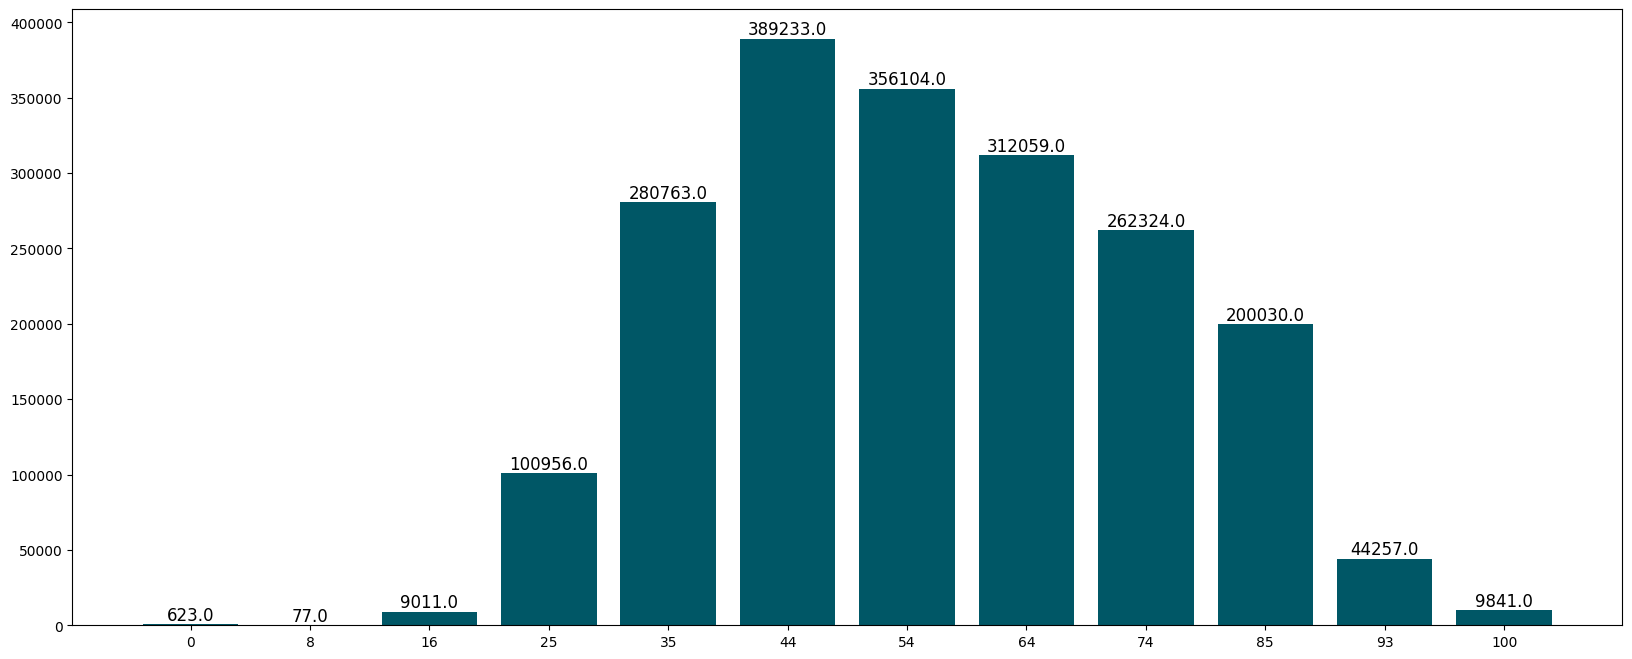

In [37]:
y = (train[train["humidity"]==0]["count"].sum(),
train[train["humidity"]==8]["count"].sum(),
train[train["humidity"]==16]["count"].sum(),
train[train["humidity"]==25]["count"].sum(),
train[train["humidity"]==35]["count"].sum(),
train[train["humidity"]==44]["count"].sum(),
train[train["humidity"]==54]["count"].sum(),
train[train["humidity"]==64]["count"].sum(),
train[train["humidity"]==74]["count"].sum(),
train[train["humidity"]==85]["count"].sum(),
train[train["humidity"]==93]["count"].sum(),
train[train["humidity"]==100]["count"].sum())

x = ["0","8","16","25","35","44","54","64","74","85","93","100"]
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)


plt.bar(x,y,color = '#005766')

We can observe that when humidity is close to 44 that is in the range of 40-50 it can be seen that the bicycle loan is highest.

# Windspeed

In [38]:
train["windspeed"].value_counts().sort_index()

windspeed
0.0000     1297
6.0032      866
7.0015     1027
8.9981     1109
11.0014    1037
12.9980    1027
15.0013     942
16.9979     807
19.0012     664
19.9995     486
22.0028     366
23.9994     272
26.0027     231
27.9993     187
30.0026     109
31.0009      89
32.9975      79
35.0008      56
36.9974      22
39.0007      26
40.9973      11
43.0006      12
43.9989       8
46.0022       3
47.9988       2
50.0021       1
51.9987       1
56.9969       2
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='Density'>

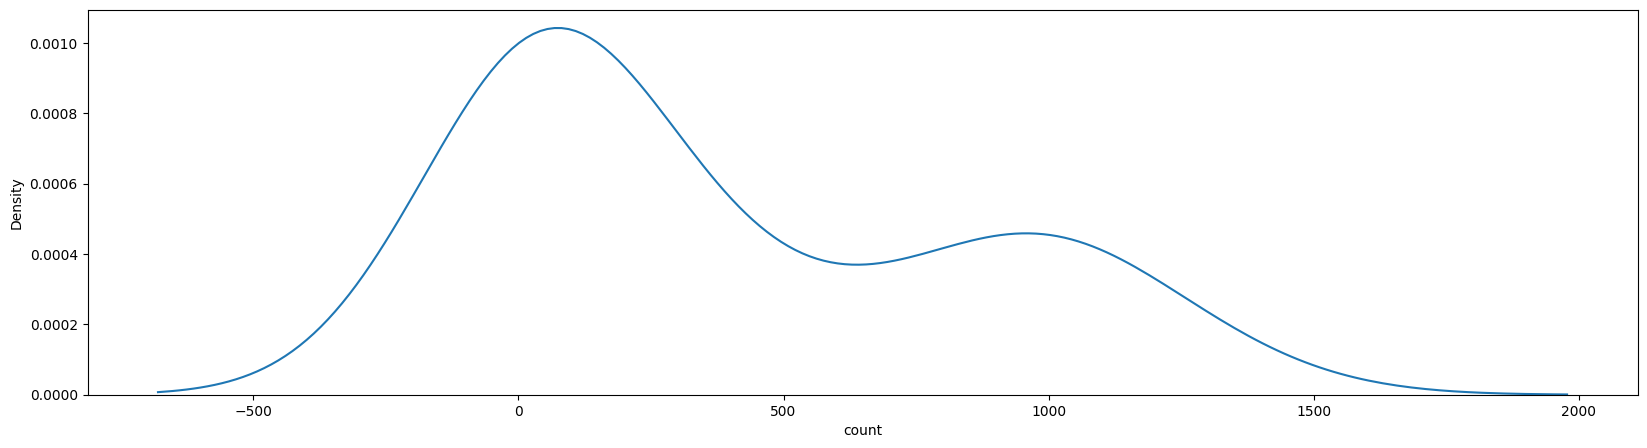

In [39]:
plt.figure(figsize=(20,5))
sn.kdeplot(train["windspeed"].value_counts().sort_index())

As no proper visualization or summary can be obtained from watching this graph we have to do proper mapping.

Since it is a data format of various and irregular patterns, it is necessary to add efficiency to visualization and machine learning analysis through mapping.

As data is divided between 1 and 60 we can distribute the data in intervals of 10.

# Windspeed change on Train Data

In [40]:
mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []

for i in range(len(train["windspeed"].value_counts())):
    dd = []
    if 1 <= train["windspeed"].value_counts().sort_index().index[i] < 10:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping1_10.append(train["windspeed"].value_counts().sort_index().index[i])
    elif 10<= train["windspeed"].value_counts().sort_index().index[i] < 20:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping10_20.append(train["windspeed"].value_counts().sort_index().index[i])    
    elif 20<= train["windspeed"].value_counts().sort_index().index[i] < 30:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping20_30.append(train["windspeed"].value_counts().sort_index().index[i])
    elif 30<= train["windspeed"].value_counts().sort_index().index[i] < 40:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping30_40.append(train["windspeed"].value_counts().sort_index().index[i])    
    elif 40<= train["windspeed"].value_counts().sort_index().index[i] < 50:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping40_50.append(train["windspeed"].value_counts().sort_index().index[i])
    elif 50<= train["windspeed"].value_counts().sort_index().index[i] < 60:
        for b in range(train["windspeed"].value_counts().sort_index().values[i]):
            mapping50_60.append(train["windspeed"].value_counts().sort_index().index[i])    


mapping_list_1 = [mapping1_10,mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60]

for i in mapping_list_1:
    print(int(np.mean(i)))

7
15
24
32
43
53


In [41]:
for i in range(len(train["windspeed"].values)):
    if 1<= train["windspeed"].values[i] < 10:
        train["windspeed"].values[i] = 7
    elif 10<= train["windspeed"].values[i] < 20:
        train["windspeed"].values[i] = 15
    elif 20<= train["windspeed"].values[i] < 30:
        train["windspeed"].values[i] = 24
    elif 30<= train["windspeed"].values[i] < 40:
        train["windspeed"].values[i] = 32
    elif 40<= train["windspeed"].values[i] < 50:
        train["windspeed"].values[i] = 43
    elif 50<= train["windspeed"].values[i] < 60:
        train["windspeed"].values[i] = 54

# Windspeed change on Test Data

In [42]:
mapping1_10 = []
mapping10_20 = []
mapping20_30 = []
mapping30_40 = []
mapping40_50 = []
mapping50_60 = []

for i in range(len(test["windspeed"].value_counts())):
    dd = []
    if 1 <= test["windspeed"].value_counts().sort_index().index[i] < 10:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping1_10.append(test["windspeed"].value_counts().sort_index().index[i])
    elif 10<= test["windspeed"].value_counts().sort_index().index[i] < 20:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping10_20.append(test["windspeed"].value_counts().sort_index().index[i])    
    elif 20<= test["windspeed"].value_counts().sort_index().index[i] < 30:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping20_30.append(test["windspeed"].value_counts().sort_index().index[i])
    elif 30<= test["windspeed"].value_counts().sort_index().index[i] < 40:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping30_40.append(test["windspeed"].value_counts().sort_index().index[i])    
    elif 40<= test["windspeed"].value_counts().sort_index().index[i] < 50:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping40_50.append(test["windspeed"].value_counts().sort_index().index[i])
    elif 50<= test["windspeed"].value_counts().sort_index().index[i] < 60:
        for b in range(test["windspeed"].value_counts().sort_index().values[i]):
            mapping50_60.append(test["windspeed"].value_counts().sort_index().index[i])    


mapping_list_1 = [mapping1_10,mapping10_20,mapping20_30,mapping30_40,
                 mapping40_50,mapping50_60]

for i in mapping_list_1:
    print(int(np.mean(i)))

7
15
24
32
42
53


In [43]:
for i in range(len(train["windspeed"].values)):
    if 1<= train["windspeed"].values[i] < 10:
        train["windspeed"].values[i] = 7
    elif 10<= train["windspeed"].values[i] < 20:
        train["windspeed"].values[i] = 15
    elif 20<= train["windspeed"].values[i] < 30:
        train["windspeed"].values[i] = 24
    elif 30<= train["windspeed"].values[i] < 40:
        train["windspeed"].values[i] = 32
    elif 40<= train["windspeed"].values[i] < 50:
        train["windspeed"].values[i] = 42
    elif 50<= train["windspeed"].values[i] < 60:
        train["windspeed"].values[i] = 53

Now let's see if we get better results by visualizing these changes.

<BarContainer object of 7 artists>

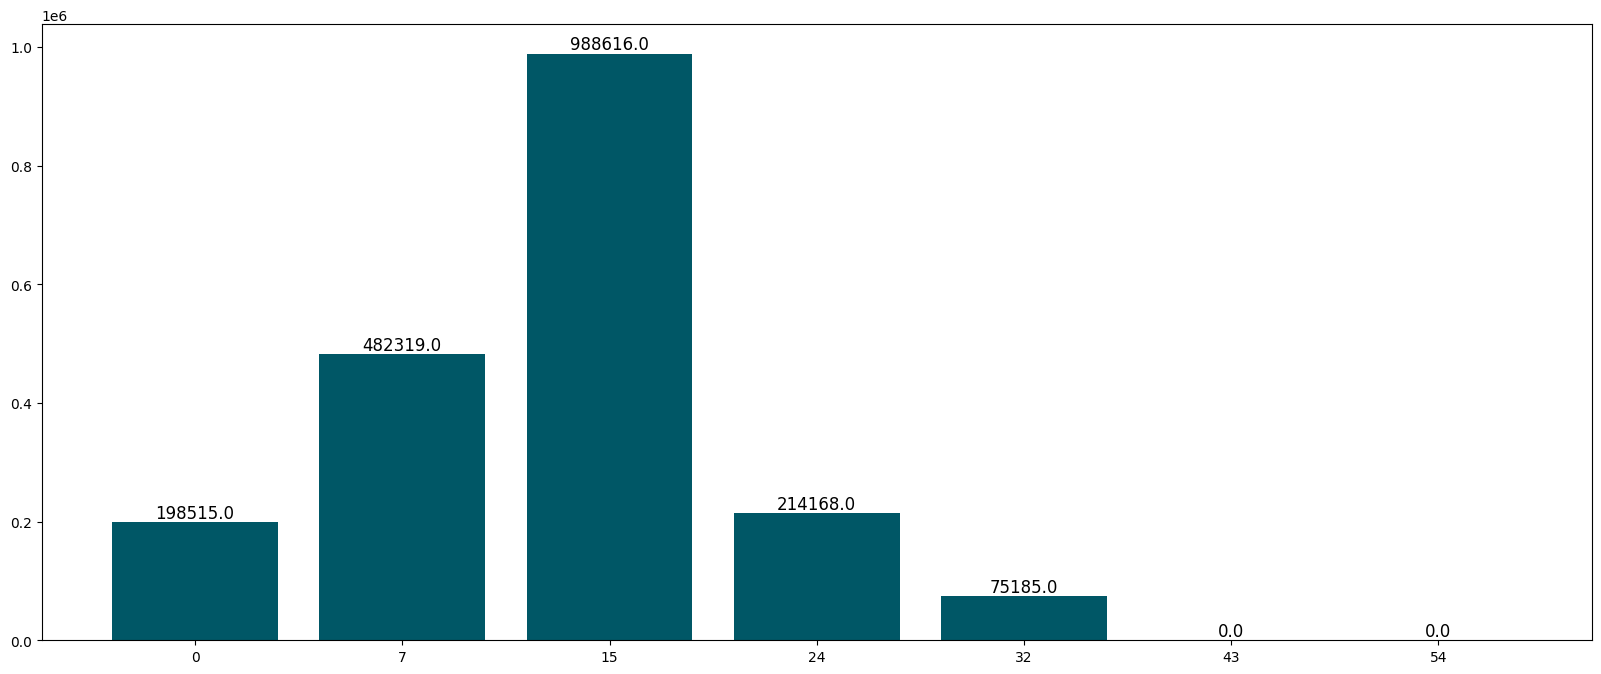

In [44]:
y = (train[train["windspeed"]==0.0]["count"].sum(),
train[train["windspeed"]==7.0]["count"].sum(),
train[train["windspeed"]==15.0]["count"].sum(),
train[train["windspeed"]==24.0]["count"].sum(),
train[train["windspeed"]==32.0]["count"].sum(),
train[train["windspeed"]==43.0]["count"].sum(),
train[train["windspeed"]==54.0]["count"].sum())


x = ["0","7","15","24","32","43","54"]
plt.figure(figsize=(20,8))
for i in range(len(x)):
    height = y[i]
    plt.text(x[i], height + 1.9, '%.1f' %height, ha='center', va='bottom', size = 12)


plt.bar(x,y,color = '#005766')

When the wind speed averaged 15, the bicycle loan is highest.

Let's now plot the correlation matrix and summarize the visualization.

In [45]:
heatmap_data = train

<Axes: >

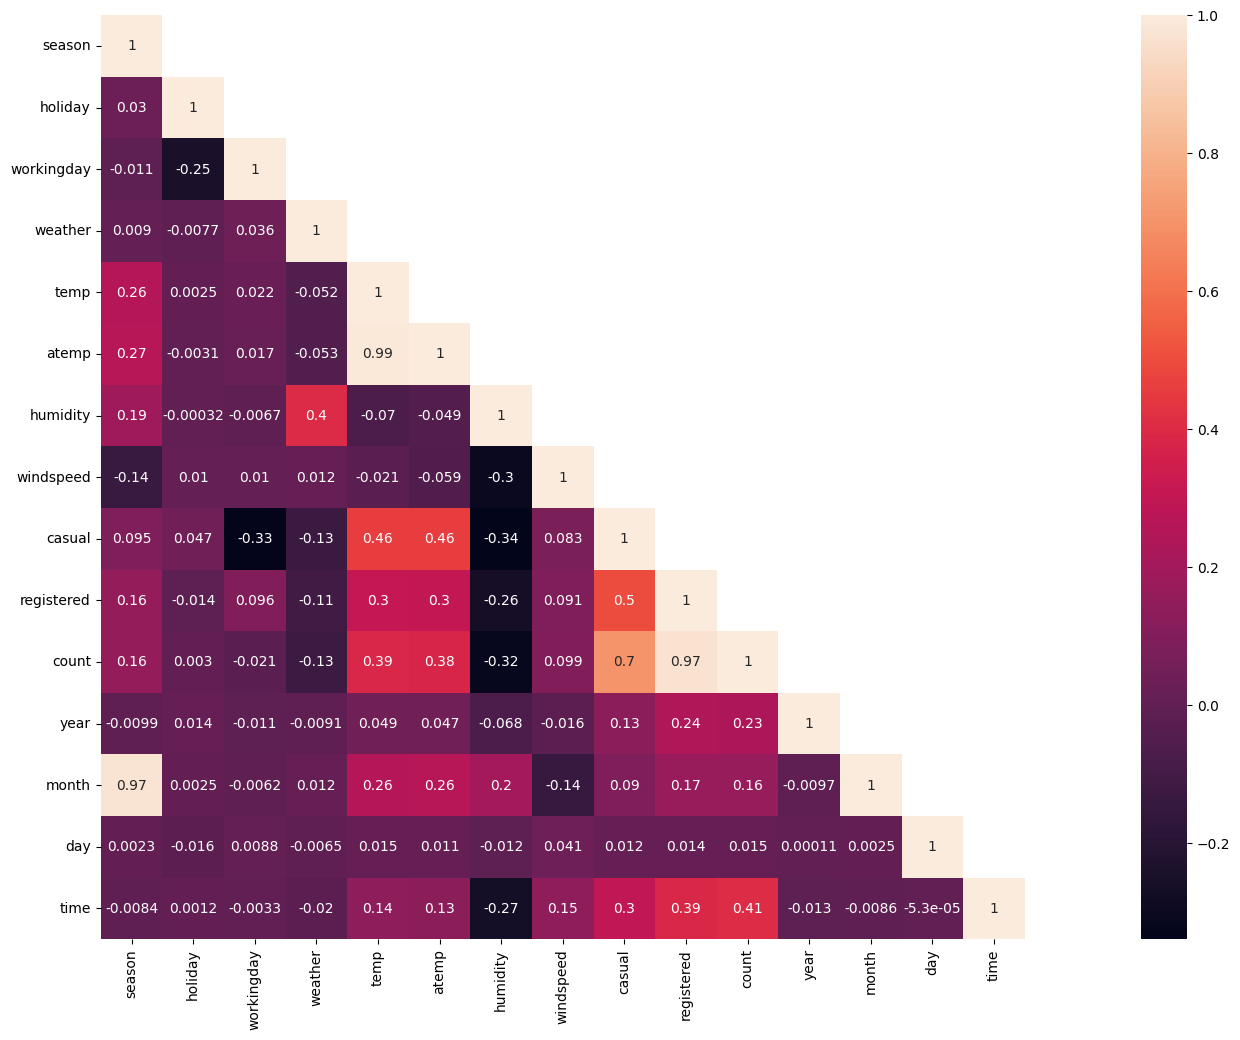

In [46]:
#corelation matrix.
cor_mat= heatmap_data[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sn.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

INFERENCES FROM THE ABOVE HEATMAP:
1. Temp and atemp are highly related as expected.

2. Humidity is inversely related to count as expected as the weather is humid people will not like to travel on a bike.

3. Casual and working day are inversely related.

4. Count and holiday are inversely related.

5. Weather and count are inversely related. For the given type of data the reason could be as weather increases from (1 to 4) implies that weather is getting more worse and so lesser people will rent bikes.

And many more...


# Now let's try training our model

In [47]:
features = ["season","holiday","workingday","weather","temp","atemp","humidity","windspeed","year","month","day","time"]

In [48]:
x_modified = train[features]
y_modified = train["count"]

In [49]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_modified,y_modified,test_size=0.25,random_state=42)

# Applying Machine Learning Models

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
import xgboost as xgb

In [51]:
"""XGBR = xgb.XGBRegressor(n_estimators=100, max_depth=5)
XGBR.fit(x_train,y_train)
pred=XGBR.predict(x_test)
acc1=np.sqrt(mean_squared_log_error(pred,y_test))
print(acc1)"""

'XGBR = xgb.XGBRegressor(n_estimators=100, max_depth=5)\nXGBR.fit(x_train,y_train)\npred=XGBR.predict(x_test)\nacc1=np.sqrt(mean_squared_log_error(pred,y_test))\nprint(acc1)'

In [52]:
models=[RandomForestRegressor(),AdaBoostRegressor(),BaggingRegressor()]
model_names=['RandomForestRegressor','AdaBoostRegressor','BaggingRegressor']
rmsle=[]
d={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(np.sqrt(mean_squared_log_error(test_pred,y_test)))
d={'Modelling Algo':model_names,'RMSLE':rmsle}   
d

{'Modelling Algo': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor'],
 'RMSLE': [0.3403607231467567, 0.9316259131530789, 0.35900462799014804]}

RandomForestRegressor shows best results on training set.

# Let's try for different parameters of RandomForestRegressor

relation_square :  0.3455738928364736


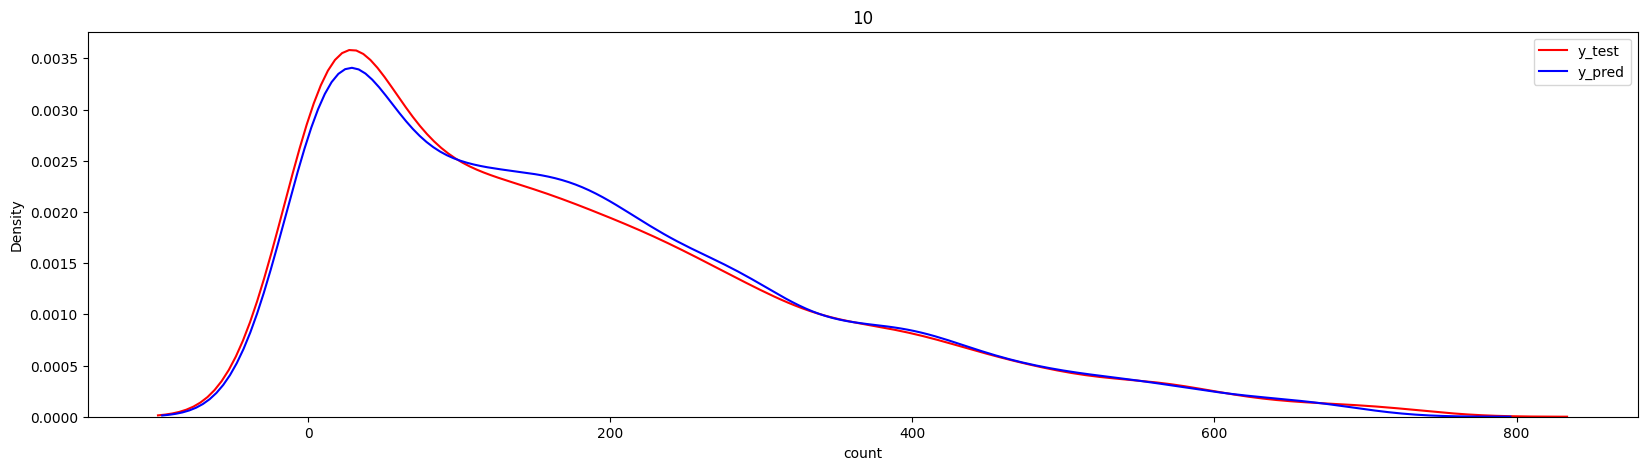

relation_square :  0.3391099347955184


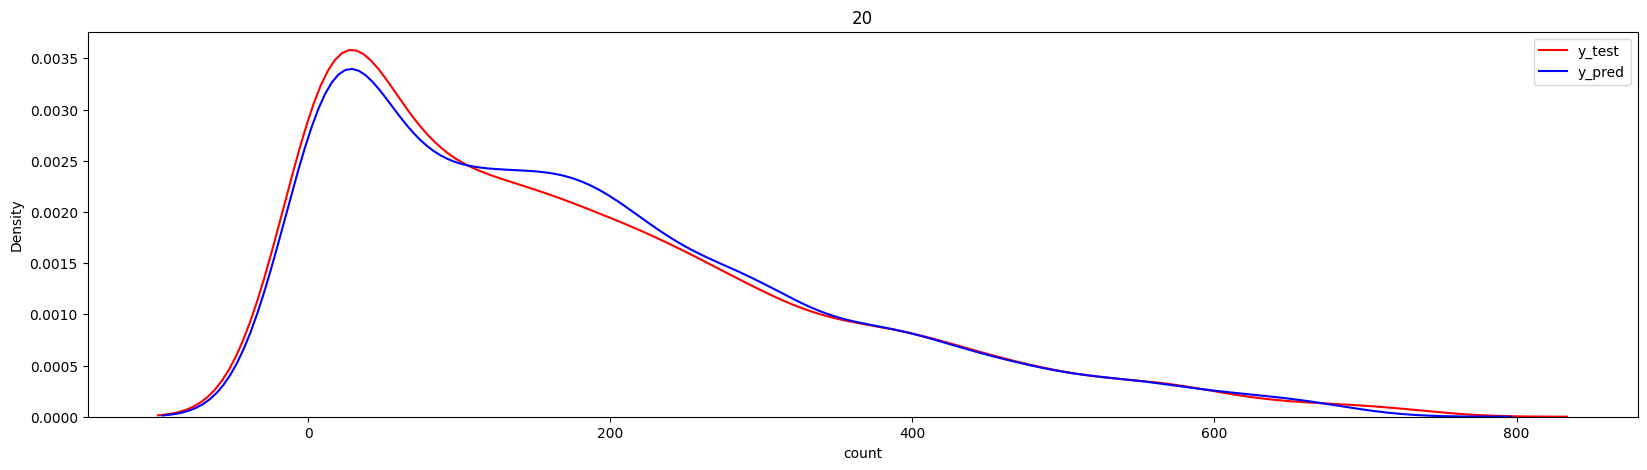

relation_square :  0.3391739588369508


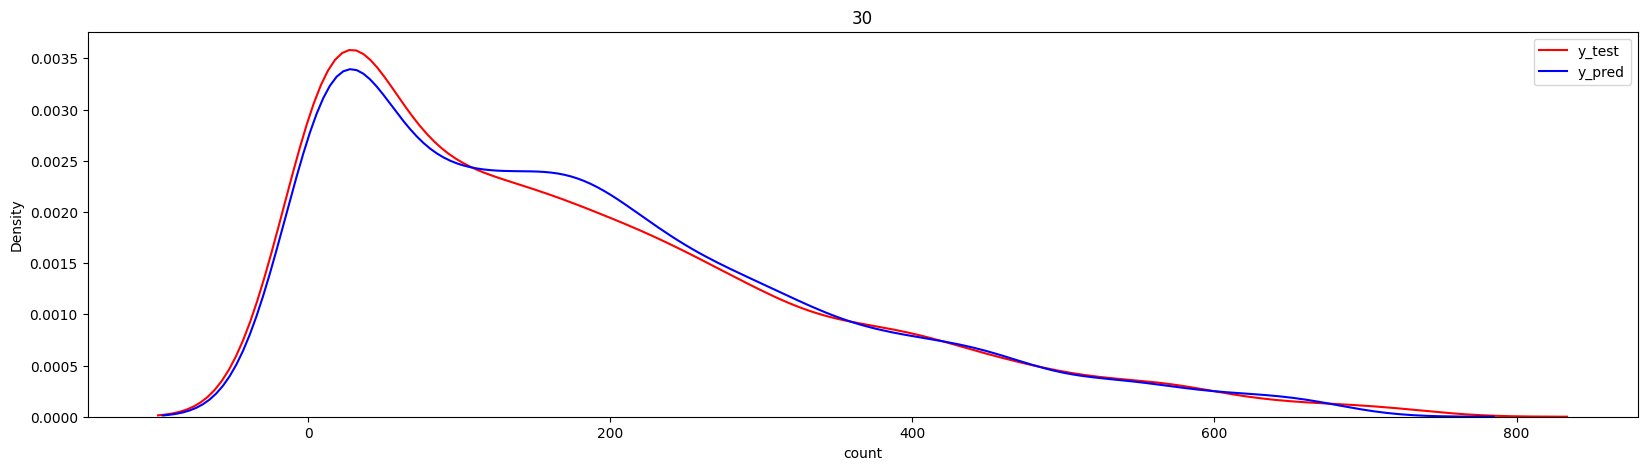

relation_square :  0.3375387764843319


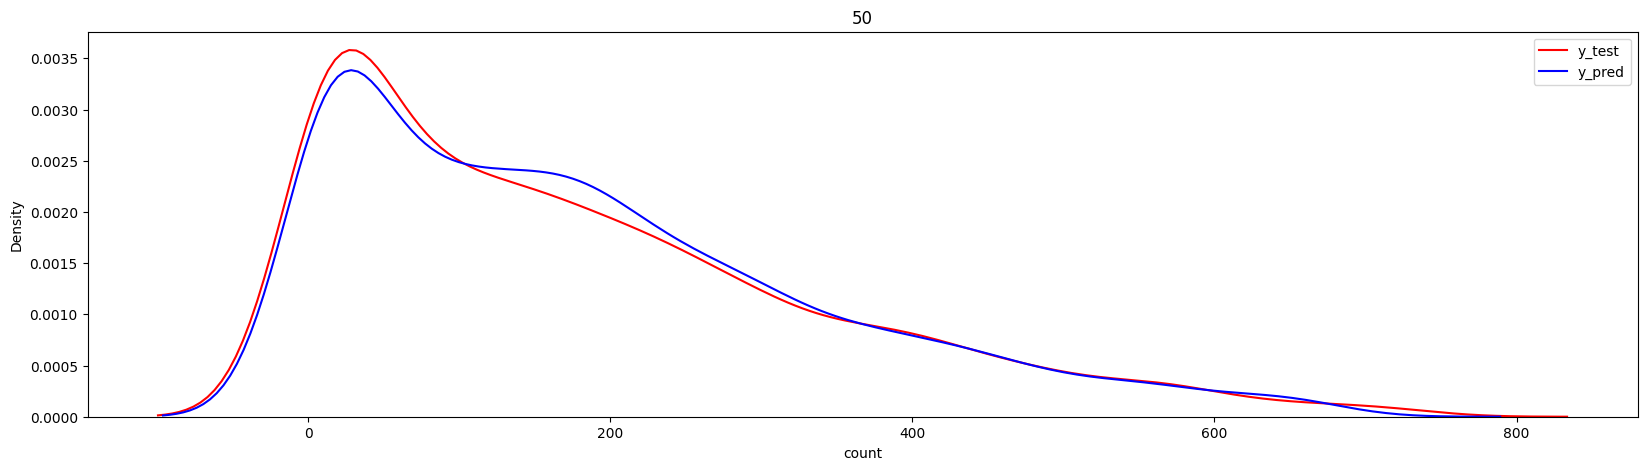

relation_square :  0.3360124354799326


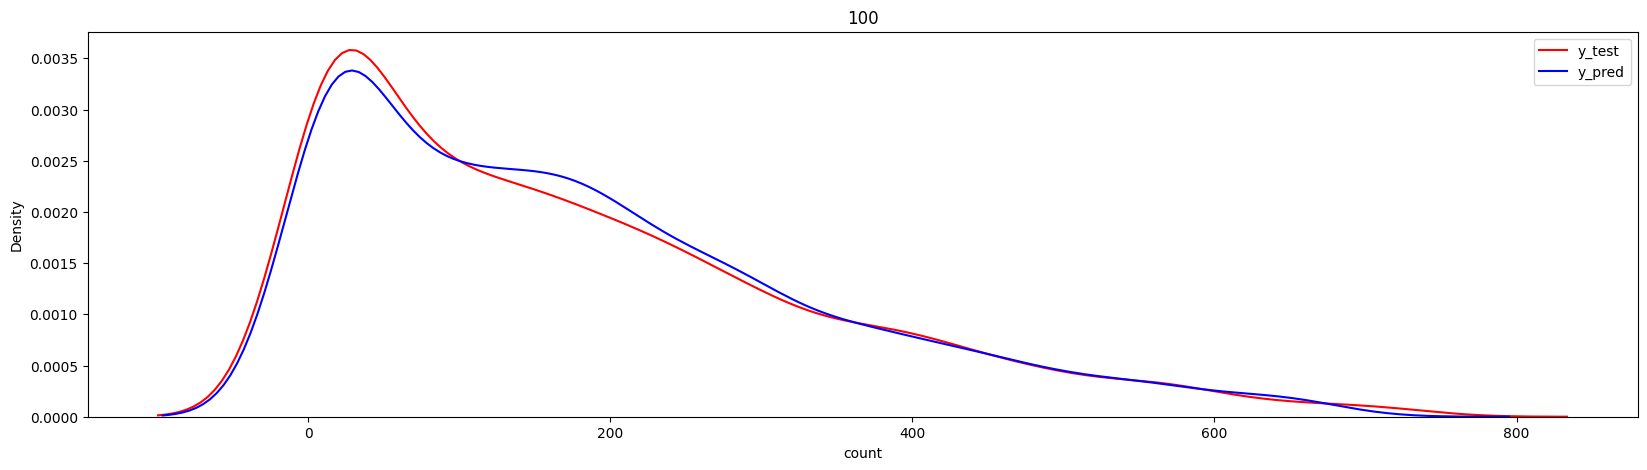

relation_square :  0.3359507248735246


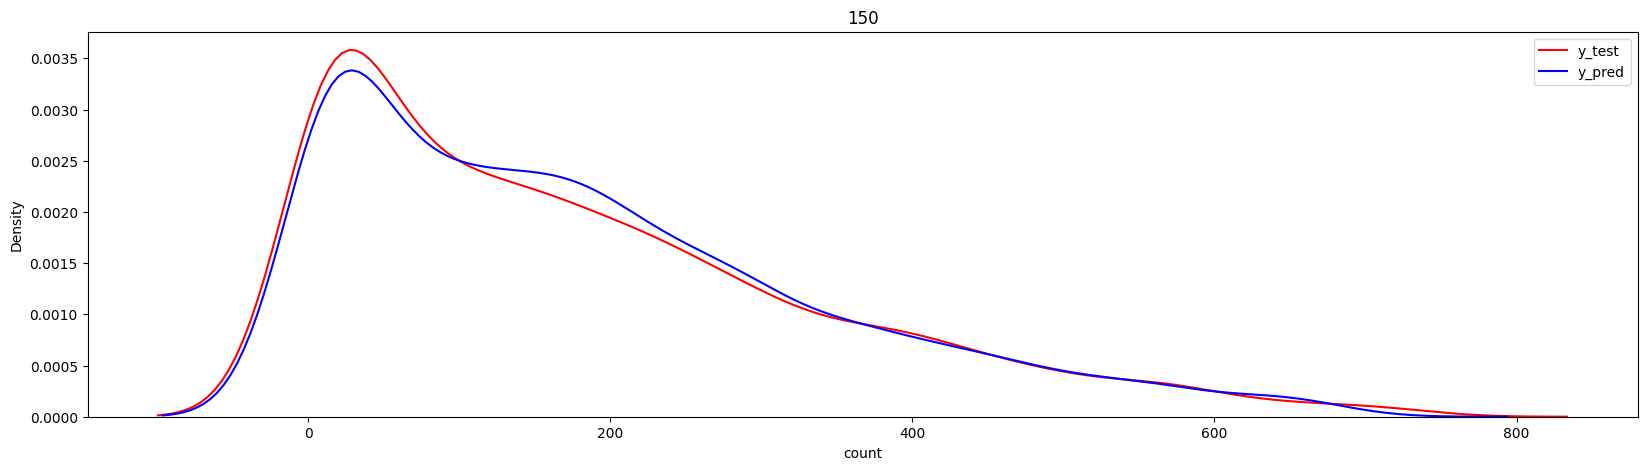

relation_square :  0.33758437688338866


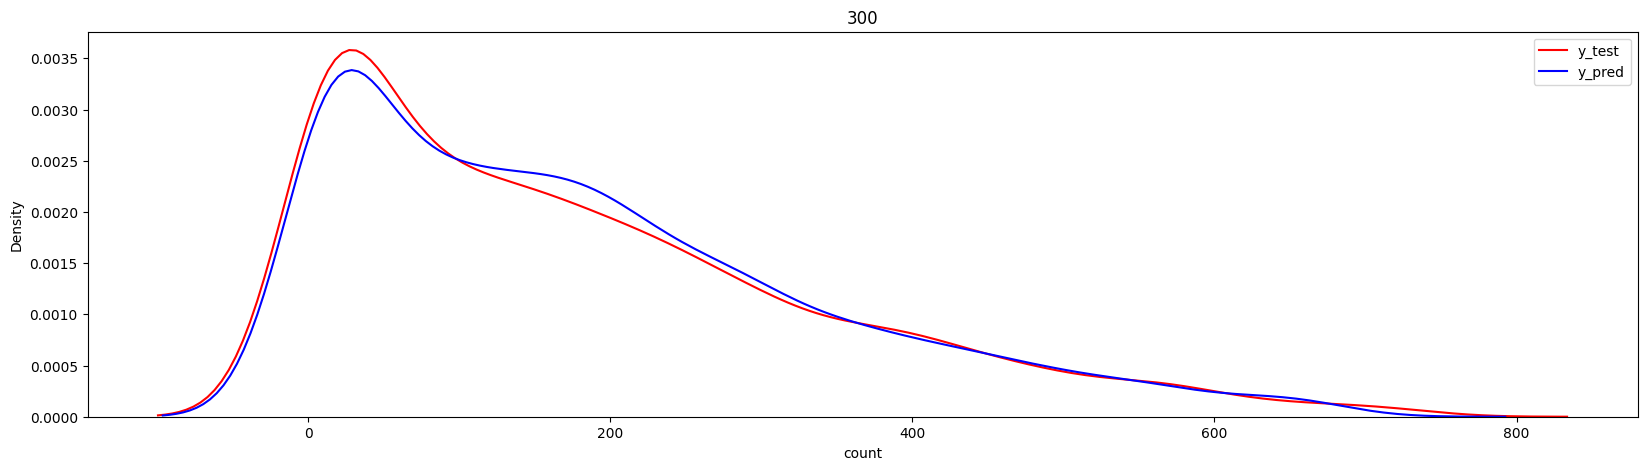

In [53]:
from sklearn.ensemble import RandomForestRegressor
# Check the result according to "n_estimators".
for i in (10, 20, 30, 50, 100, 150,300):
    model = RandomForestRegressor(n_estimators= i,n_jobs=-1, random_state = 15)
    model.fit(x_train,y_train)
    # The higher the "n_estimators" value, the higher the accuracy, 
    # but the more computational it takes for the computer to calculate and derive results. 
    # I set the value to 300 appropriately.
    pred1 = model.predict(x_test)
    relation_square = np.sqrt(mean_squared_log_error(pred1, y_test))
    print('relation_square : ', relation_square)
    plt.figure(figsize=(20,5))
    
    ax1 = sn.kdeplot(y_test,label = 'y_test',color="red")
    ax2 = sn.kdeplot(pred1,label = 'y_pred',color="blue")
    
    plt.title(i)
    plt.legend()
    plt.show()

# Let's try for different parameters of BaggingRegressor

relation_square :  0.34617784187971695


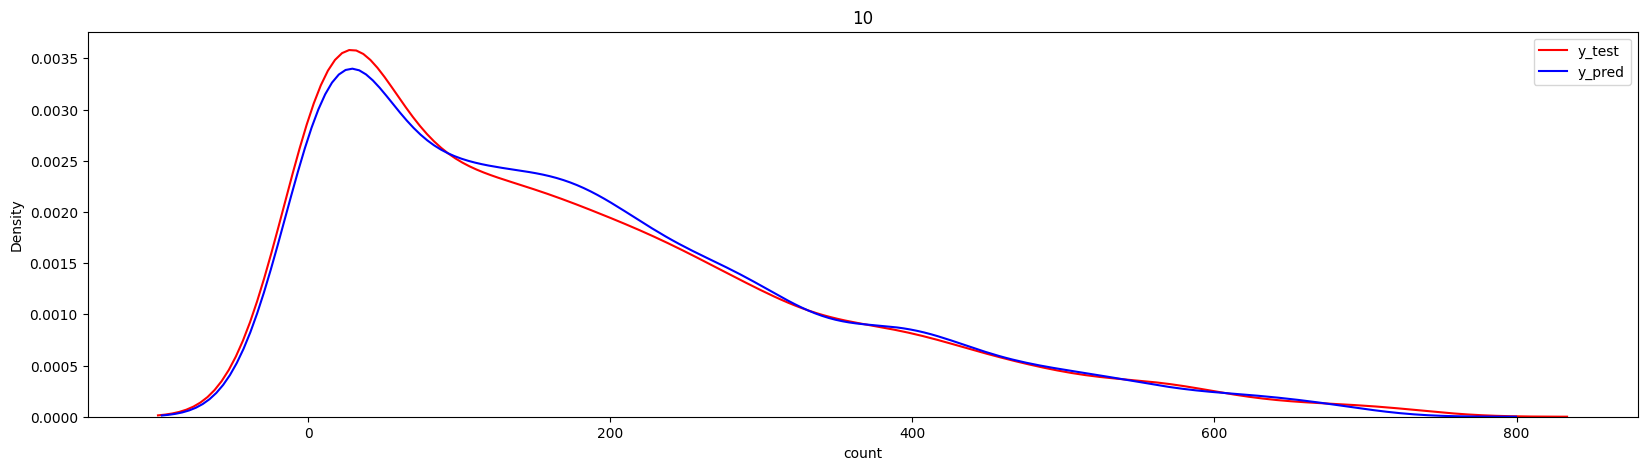

relation_square :  0.3404838890994888


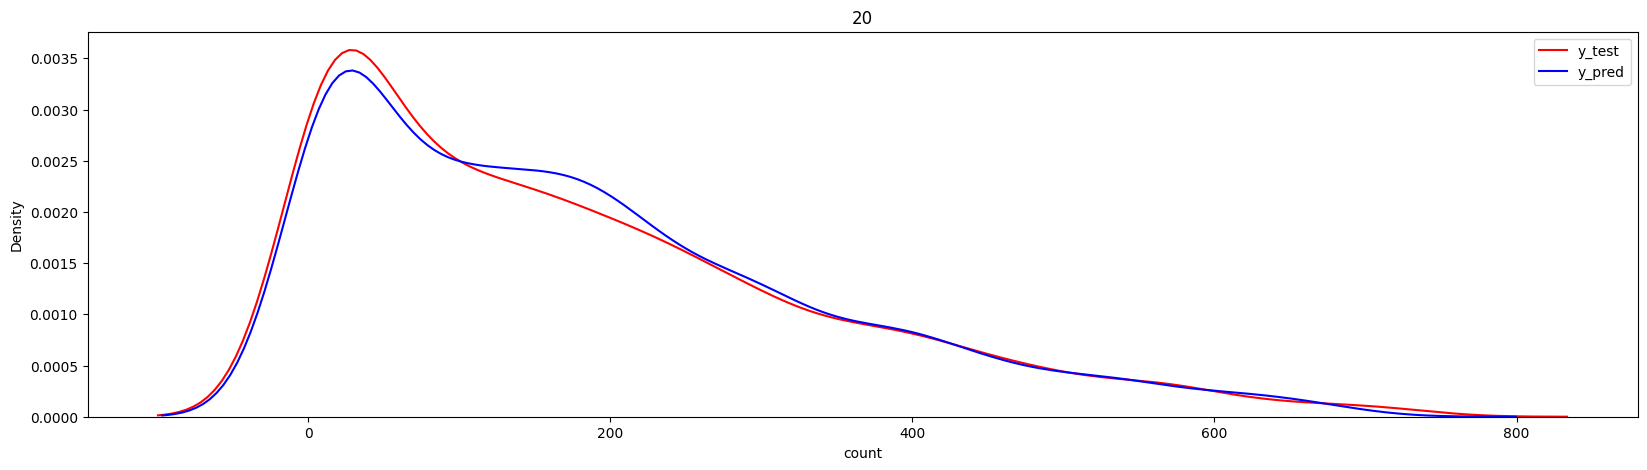

relation_square :  0.34042650370189487


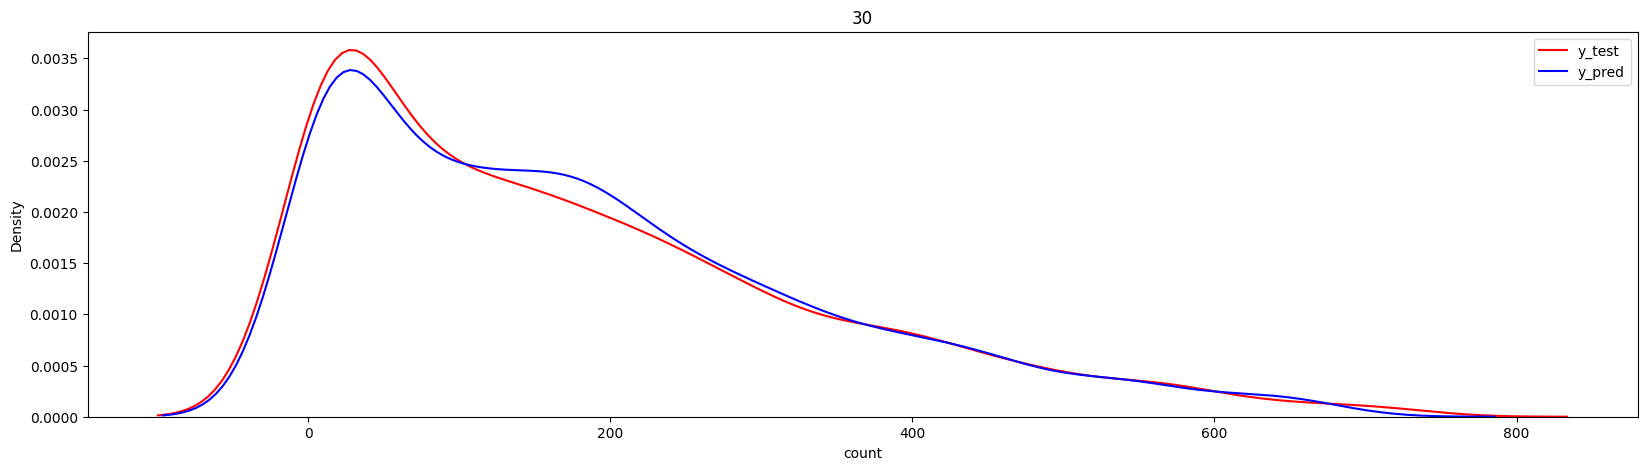

relation_square :  0.33738098352853046


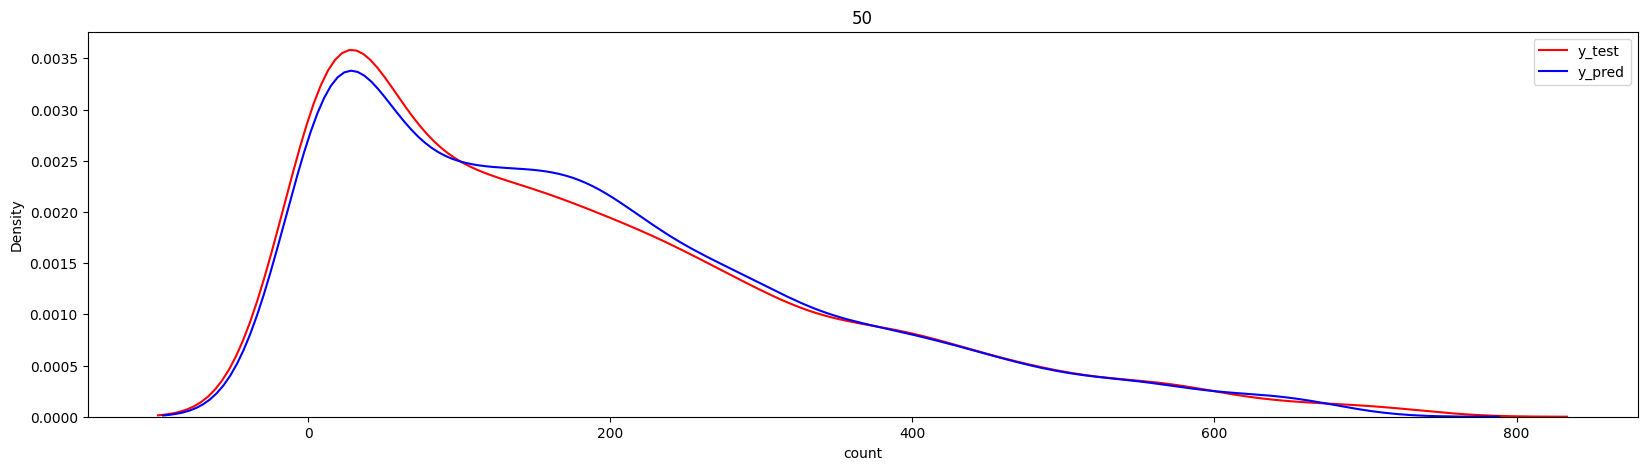

relation_square :  0.33582206398371084


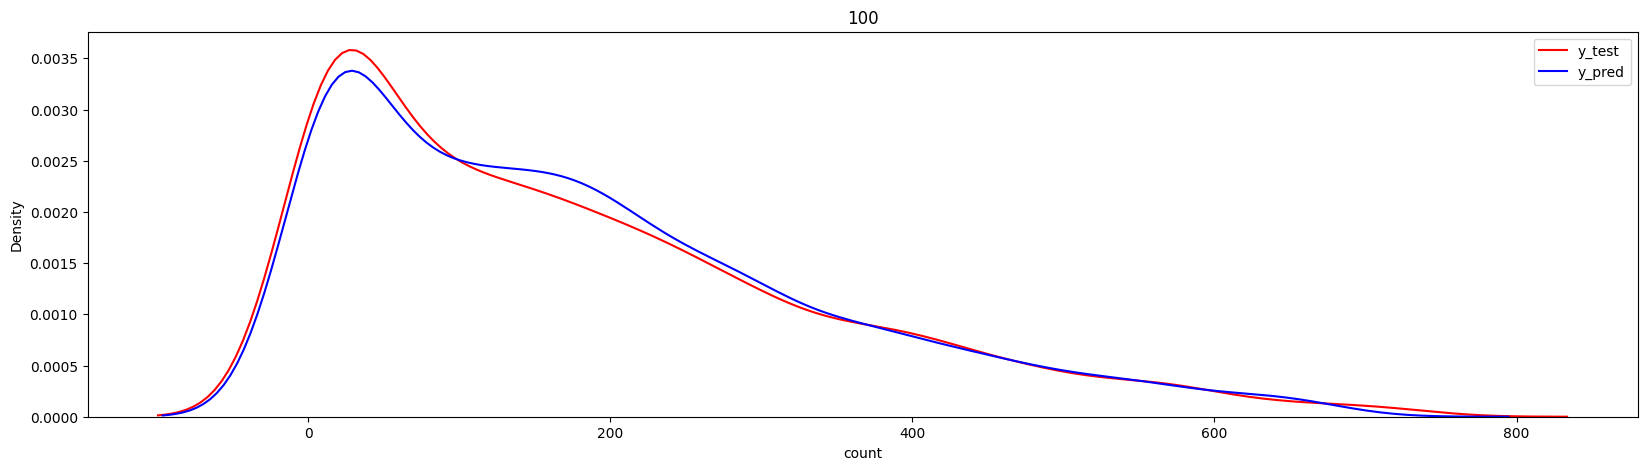

relation_square :  0.33675263183318127


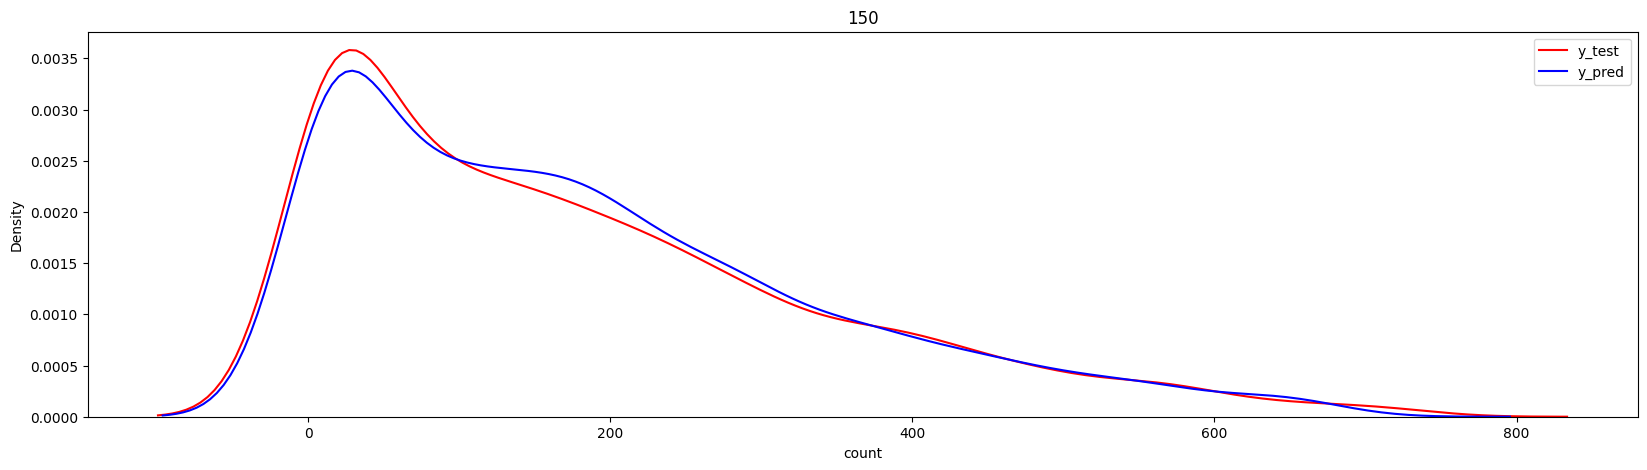

relation_square :  0.3375137653711383


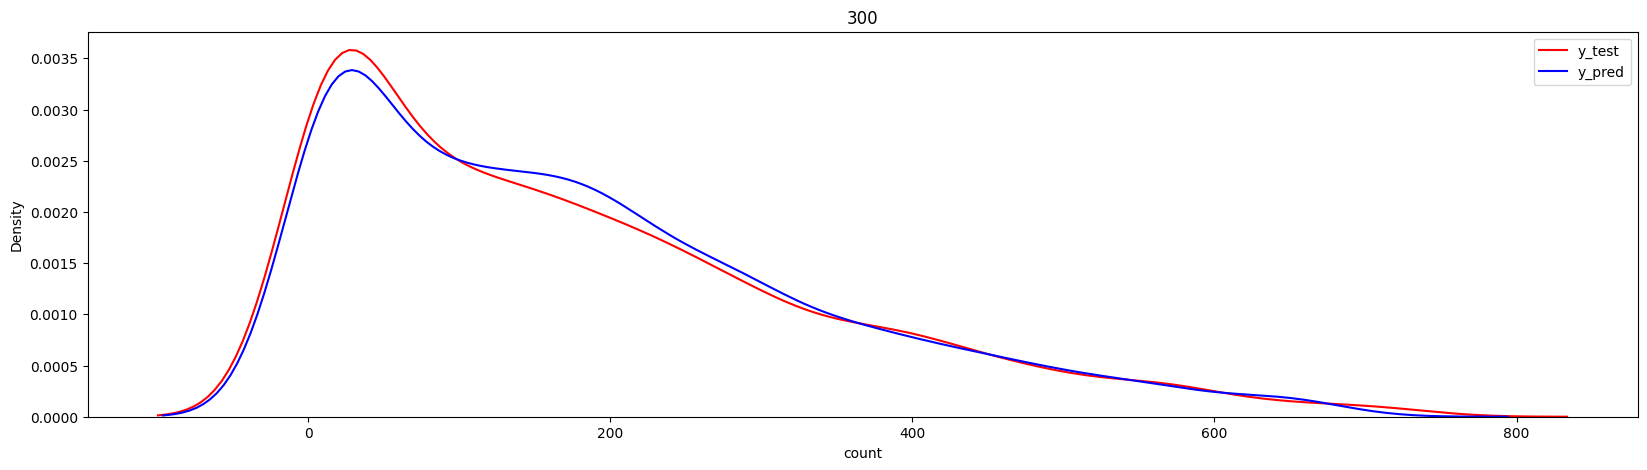

In [54]:
# Check the result according to "n_estimators".
for i in (10, 20, 30, 50, 100, 150,300):
    model_2 = BaggingRegressor(n_estimators= i,n_jobs=-1, random_state = 15)
    model_2.fit(x_train,y_train)
    # The higher the "n_estimators" value, the higher the accuracy, 
    # but the more computational it takes for the computer to calculate and derive results. 
    # I set the value to 300 appropriately.
    pred2 = model_2.predict(x_test)
    relation_square = np.sqrt(mean_squared_log_error(pred2, y_test))
    print('relation_square : ', relation_square)
    plt.figure(figsize=(20,5))
    
    ax1 = sn.kdeplot(y_test,label = 'y_test',color="red")
    ax2 = sn.kdeplot(pred2,label = 'y_pred',color="blue")
    
    plt.title(i)
    plt.legend()
    plt.show()

In [55]:
model_ml = BaggingRegressor(n_estimators=100, n_jobs = -1 , random_state = 0)
model_ml.fit(x_train, y_train)

predictions_ml = model_ml.predict(test)
predictions_ml

array([ 15.07,   5.29,   5.39, ..., 159.23, 109.67,  74.13])

In [56]:
ml_predictions=predictions_ml

In [57]:
x_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,time
5007,4,0,1,1,17.22,21.210,35,0.0,2011,12,2,17
6384,1,0,0,2,14.76,18.180,93,7.0,2012,3,3,6
1127,1,0,1,2,13.94,15.910,54,15.0,2011,3,11,15
3997,3,0,0,2,21.32,25.000,74,15.0,2011,9,17,14
8595,3,0,1,1,34.44,39.395,44,15.0,2012,7,19,12
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1,0,0,1,6.56,8.335,44,15.0,2012,1,14,2
5191,4,0,0,1,11.48,12.880,64,15.0,2011,12,10,9
5390,4,0,0,1,11.48,13.635,44,15.0,2011,12,18,16
860,1,0,0,1,15.58,19.695,16,32.0,2011,2,19,7


# Deep Learning Model


In [58]:
import tensorflow as tf
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Dense(units=32, activation='relu'))
model1.add(tf.keras.layers.Dense(units=64, activation='relu'))
model1.add(tf.keras.layers.Dense(units=128, activation='relu'))
#model.add(tf.keras.layers.Dense(units=256, activation='relu'))
#model.add(tf.keras.layers.Dense(units=512, activation='relu'))
model1.add(tf.keras.layers.Dense(units=256, activation='relu'))
model1.add(tf.keras.layers.Dense(units=64, activation='relu'))
model1.add(tf.keras.layers.Dense(units=32, activation='relu'))
model1.add(tf.keras.layers.Dense(units=16, activation='relu'))
model1.add(tf.keras.layers.Dense(units=1,activation="linear"))

# # Compile the model with a mean squared error loss function
# model.compile(optimizer='adam', loss='mean_squared_error')

# Compile the model with a mean squared error loss function and L2 regularization
model1.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredLogarithmicError(),metrics='mse')

# Train the model on the train data
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
history = model1.fit(x_train, y_train, epochs=100, verbose = 1,validation_data=[x_test,y_test])

# Predict the values of y for the test data
y_pred = model1.predict(x_test)
print("Predicted y values:", y_pred)

Epoch 1/100
252/252 [==============================] - 3s 3ms/step - loss: 1.9453 - mse: 35065.3750 - val_loss: 1.5588 - val_mse: 27460.9648
Epoch 2/100
252/252 [==============================] - 1s 3ms/step - loss: 1.4192 - mse: 25904.9688 - val_loss: 1.1139 - val_mse: 20862.6836
Epoch 3/100
252/252 [==============================] - 1s 3ms/step - loss: 1.1902 - mse: 22220.2305 - val_loss: 1.1579 - val_mse: 23501.7422
Epoch 4/100
252/252 [==============================] - 1s 3ms/step - loss: 1.1581 - mse: 22156.7344 - val_loss: 1.0245 - val_mse: 20926.0020
Epoch 5/100
252/252 [==============================] - 1s 3ms/step - loss: 1.0987 - mse: 21894.8008 - val_loss: 1.1522 - val_mse: 25446.5156
Epoch 6/100
252/252 [==============================] - 1s 3ms/step - loss: 1.1226 - mse: 22710.5781 - val_loss: 1.0650 - val_mse: 18032.6133
Epoch 7/100
252/252 [==============================] - 1s 3ms/step - loss: 1.0452 - mse: 22131.7461 - val_loss: 0.9703 - val_mse: 21756.3105
Epoch 8/100
2

In [59]:
err = np.sqrt(mean_squared_log_error(y_pred, y_test))
err

0.495629812358447

In [60]:
deep_learning_prediction = model1.predict(test)

#deep_learning_prediction = np.array(y_pred)


203/203 [==============================] - 0s 1ms/step


In [61]:
print(len(deep_learning_prediction))
print(len(ml_predictions))
print(len(y_train))

6493
6493
8054


In [62]:
i = 100
print(deep_learning_prediction[i][0],ml_predictions[i],y_train[i])

78.26063 77.52 115


In [63]:
import math
final_pred = []
for i in range(6493):
    final_pred.append((deep_learning_prediction[i][0]+ml_predictions[i])/2)

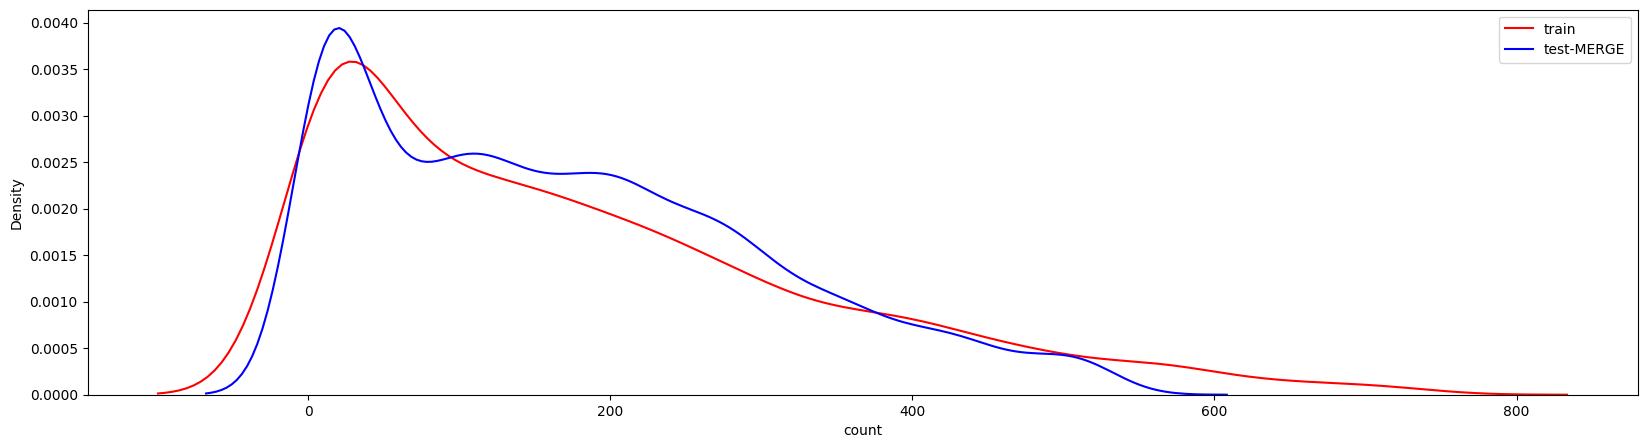

In [64]:
plt.figure(figsize=(20,5))
ax1 = sn.kdeplot(y_test, label = 'train',color="red")
ax2 = sn.kdeplot(final_pred, label = 'test-MERGE',color="blue")

plt.legend()
plt.show()

In [65]:
submission = pd.read_csv("/kaggle/input/bike-sharing-demand/sampleSubmission.csv")
submission["count"] = final_pred
submission

,datetime,count
0,2011-01-20 00:00:00,15.581164
1,2011-01-20 01:00:00,8.658714
2,2011-01-20 02:00:00,5.083800
3,2011-01-20 03:00:00,2.823563
4,2011-01-20 04:00:00,2.196543
...,...,...
6488,2012-12-31 19:00:00,224.347586
6489,2012-12-31 20:00:00,162.318899
6490,2012-12-31 21:00:00,126.982409
6491,2012-12-31 22:00:00,95.477227


In [66]:
submission.to_csv("submission.csv",index=False)

In [67]:
submission = pd.read_csv("submission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,15.581164
1,2011-01-20 01:00:00,8.658714
2,2011-01-20 02:00:00,5.083800
3,2011-01-20 03:00:00,2.823563
4,2011-01-20 04:00:00,2.196543
